# ## Install necessary libraries

In [1]:

# First, we need to install the required libraries. Run the following cell to install them.
!pip install torch transformers datasets wandb


# ## Import libraries

In [2]:
# Now, let's import the necessary libraries.
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW, get_linear_schedule_with_warmup
import wandb
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
import random

# ## Set up Weights and Biases

In [4]:
# Weights and Biases (W&B) is a tool for experiment tracking. We will use it to log our training metrics.

#wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
#wandb: You can find your API key in your browser here: https://wandb.ai/authorize

wandb.init(project="gpt2-next-word-prediction", name="Week4-Lecture0-PyTorch-Introduction.ipynb")
wandb.login(key="3c6858d067cbb8f93980d6f94daa5ea96d42548a")



wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

# # Data Preparation
# ## Load and preprocess dataset

In [5]:
# We will use the Wikitext-2 dataset for this tutorial. It is a popular dataset for language modeling tasks.
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

In [6]:
# Let's take a look at a few examples from the dataset.
print(dataset['train'][5]['text'])

 It met with positive sales in Japan , and was praised by both Japanese and western critics . After release , it received downloadable content , along with an expanded edition in November of that year . It was also adapted into manga and an original video animation series . Due to low sales of Valkyria Chronicles II , Valkyria Chronicles III was not localized , but a fan translation compatible with the game 's expanded edition was released in 2014 . Media.Vision would return to the franchise with the development of Valkyria : Azure Revolution for the PlayStation 4 . 



In [7]:
# We need to tokenize the text data. We will use the GPT-2 tokenizer from HuggingFace's Transformers library.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

In [8]:
# Add a padding token to the tokenizer.
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

1

In [9]:
# We define a function to tokenize the dataset.
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=128)


In [10]:
# Apply the tokenizer to the dataset.
tokenized_datasets = dataset.map(tokenize_function, batched=True)


Map:   0%|          | 0/36718 [00:00<?, ? examples/s]

Map:   0%|          | 0/3760 [00:00<?, ? examples/s]

In [11]:
# Let's check the tokenized data.
print(tokenized_datasets['train'][0])

{'text': '', 'input_ids': [50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257, 50257], 'attention_mask': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [12]:
# For demo purposes, let's take a small subset of the dataset.
def get_subset(dataset, num_samples):
    indices = random.sample(range(len(dataset)), num_samples)
    return Subset(dataset, indices)

In [13]:
# Split the data into training and evaluation sets.
# train_dataset = tokenized_datasets['train']
# eval_dataset = tokenized_datasets['validation']

train_dataset = get_subset(tokenized_datasets['train'], 500)  # 500 samples from training set
eval_dataset = get_subset(tokenized_datasets['validation'], 100)  # 100 samples from validation set

# ## Define DataLoader

In [14]:
# We need to create DataLoaders to feed the data into our model during training and evaluation.
def data_collator(data):
    input_ids = torch.tensor([f["input_ids"] for f in data])
    attention_mask = torch.tensor([f["attention_mask"] for f in data])
    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": input_ids}


In [15]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=data_collator)
eval_dataloader = DataLoader(eval_dataset, batch_size=8, collate_fn=data_collator)


# # Model Definition
# ## Define GPT-2 model

In [24]:
# We will use the GPT-2 model from HuggingFace's Transformers library. We need to resize the token embeddings to match the size of our tokenizer.
model = GPT2LMHeadModel.from_pretrained('gpt2')
model.resize_token_embeddings(len(tokenizer))

Embedding(50258, 768)

# ## Calculate perplexity

In [25]:
# Perplexity is a common metric for evaluating language models. It is the exponential of the average negative log-likelihood of a sequence.
def calculate_perplexity(loss):
    return torch.exp(torch.tensor(loss))

In [26]:
# Let's evaluate the pretrained model on the validation set. We will calculate the average loss and perplexity.
eval_loss_values = []

model.eval()
eval_loss = 0
for batch in eval_dataloader:
    with torch.no_grad():
        outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()
        eval_loss_values.append(loss.item())

avg_eval_loss = eval_loss / len(eval_dataloader)
perplexity = calculate_perplexity(avg_eval_loss)
print(f"Evaluation Loss: {avg_eval_loss}")
print(f"Perplexity: {perplexity}")

Evaluation Loss: 41.99241799574632
Perplexity: 1.726134849317634e+18


In [27]:
# ## Log model with Weights and Biases
wandb.watch(model, log="all")

[]

# # Training Loop
# ## Define training parameters

In [28]:
# Let's set up our training parameters. We will train for 3 epochs, use the AdamW optimizer, and set up a learning rate scheduler.
epochs = 20
optimizer = AdamW(model.parameters(), lr=5e-5)
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/Users/sangeethreddy/.virtualenvs/servc_dsk/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


# ## Training loop

In [29]:
# Now, we will define the training loop. We will iterate over the training data, perform forward and backward passes, and update the model parameters.
training_loss_values = []

model.train()
for epoch in range(epochs):
    total_loss = 0
    for batch in train_dataloader:
        optimizer.zero_grad()
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        scheduler.step()
        wandb.log({"loss": loss.item()})

    avg_train_loss = total_loss / len(train_dataloader)
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_train_loss}")


Epoch 1/20, Training Loss: 4.096096795939264
Epoch 2/20, Training Loss: 1.7236736653343079
Epoch 3/20, Training Loss: 1.5637030137909784
Epoch 4/20, Training Loss: 1.5084220670045367
Epoch 5/20, Training Loss: 1.6360897705668496
Epoch 6/20, Training Loss: 1.4499379580929166
Epoch 7/20, Training Loss: 1.400705458389388
Epoch 8/20, Training Loss: 2.8705456025070615
Epoch 9/20, Training Loss: 3.8904162560190474
Epoch 10/20, Training Loss: 3.1468176619401054
Epoch 11/20, Training Loss: 2.978838837809033
Epoch 12/20, Training Loss: 2.9443939186277843
Epoch 13/20, Training Loss: 2.9242367053788807
Epoch 14/20, Training Loss: 2.800061833290827
Epoch 15/20, Training Loss: 2.8066132756925763
Epoch 16/20, Training Loss: 2.766707059882936
Epoch 17/20, Training Loss: 2.753734940810809
Epoch 18/20, Training Loss: 2.70892648020434
Epoch 19/20, Training Loss: 2.7275393132179504
Epoch 20/20, Training Loss: 2.716942758787246


In [20]:
# ## Save training loss values
with open("training_loss_values.txt", "w") as f:
    for value in training_loss_values:
        f.write(f"{value}\n")

# # Evaluation

In [23]:
# Let's evaluate the model on the validation set. We will calculate the average loss and perplexity.
eval_loss_values = []

model.eval()
eval_loss = 0
for batch in eval_dataloader:
    with torch.no_grad():
        outputs = model(**batch)
        loss = outputs.loss
        eval_loss += loss.item()
        eval_loss_values.append(loss.item())

avg_eval_loss = eval_loss / len(eval_dataloader)
perplexity = calculate_perplexity(avg_eval_loss)
print(f"Evaluation Loss: {avg_eval_loss}")
print(f"Perplexity: {perplexity}")

Evaluation Loss: 2.307636160116929
Perplexity: 10.050639152526855


In [38]:
# ## Save evaluation loss values
with open("eval_loss_values.txt", "w") as f:
    for value in eval_loss_values:
        f.write(f"{value}\n")

# ## Plot loss curves

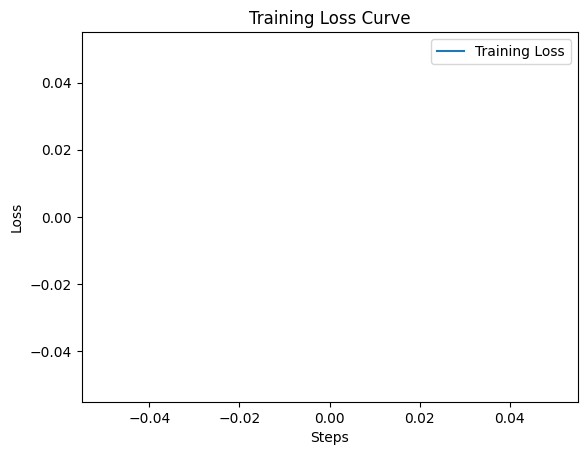

In [39]:
# Let's plot the training loss curve to visualize the model's performance over time.

plt.plot(training_loss_values, label="Training Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

# # References

# - PyTorch tutorials: https://pytorch.org/tutorials/
# - HuggingFace Transformers: https://huggingface.co/transformers/
# - Weights and Biases: https://wandb.ai/